In [1]:
import pandas as pd
import numpy as np
import random
data=pd.read_csv("FAOLEX_ALL.csv")
print(data.keys())
np.random.seed(69)
random.seed(69)

Index(['Record Id', 'Record URL', 'Document URL', 'Title', 'Original title',
       'Date of original text', 'Last amended date', 'Available website',
       'Language of document', 'Country/Territory', 'Regional organizations',
       'Territorial subdivision', 'Type of text', 'Repealed', 'Abstract',
       'Primary subjects', 'Domain', 'Keywords'],
      dtype='object')


In [2]:
# remve repealed legislation
data["Repealed"].fillna(value = "N", inplace=True)
data["Repealed"] = pd.Categorical(data["Repealed"])
data=data[data["Repealed"]=="N"]


In [3]:
import nltk
keywords_nofilter=list(data["Keywords"])
country_nofilter=list(data["Country/Territory"])
i=0
# Split alle keywords op i en liste og ændrer nan til at være en str med Nan
for words in keywords_nofilter:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="NaN"
    if type(country_nofilter[i])!=str:
        country_nofilter[i]="NaN"
    keywords_nofilter[i]=words.split(";")
    i+=1


In [4]:
#Remove Nan from keywords and countries
keywords = []
country = []

for i in range(len(keywords_nofilter)):
    if keywords_nofilter[i] != ["NaN"] and country_nofilter[i]!="NaN":
        keywords.append(keywords_nofilter[i])
        country.append(country_nofilter[i])


In [5]:
from top2vec import Top2Vec
model = Top2Vec.load("top2vec_model")

C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopyth

In [6]:
# Compute uniqe countries --> i.e. remove agreement "countries" 
country_new=[]
countries = {}
i=0
for coun in country:
    if len(coun.split(";"))>=2:
        for c in coun.split("; "):
            if c in countries.keys():
                country_new.append(c)
            else:
                country_new.append(c)
                countries[c]=i
                i+=1
    else:
        if coun in countries.keys():
            country_new.append(coun)
        else:
            country_new.append(coun)
            countries[coun]=i
            i+=1

In [7]:
# Compute country x topic occurence matrix
topic_sizes, topic_nums = model.get_topic_sizes(reduced=False)
country_topic_matrix = np.zeros((len(set(country_new)),len(topic_nums)))

for num in topic_nums:
    # For each topic get the corresponding documents
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=num,num_docs=topic_sizes[num],reduced=False)
    for id in document_ids:
        # Find the documents' countries and add it to the co-occurence matrix
        if len(country[id].split(";"))>=2:
            for c in country[id].split("; "):
                 country_topic_matrix[countries[c],num] +=1
        else:
            country_topic_matrix[countries[country[id]],num] +=1



In [8]:
 
def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)

#Standardisering
#for i in range(len(countries)):
 #   country_topic_matrix[i,:]=country_topic_matrix[i,:]/country_new.count(countries_swap[i]) 


In [9]:
def square_rooted(x):
        return np.sqrt(sum([a*a for a in x]))
def co_occurence(country_new,similarity):
    country_co_occurrence = np.zeros((len(set(country_new)),len(set(country_new))))

    for i in range(len(set(country_new))):
        for j in range(len(set(country_new))):
            if similarity == "correlation":
                # Correlation
                country_co_occurrence[i,j] = np.exp(np.corrcoef(country_topic_matrix[i,:],country_topic_matrix[j,:])[0,1])/np.exp(1)
            elif similarity == "cosine":
                #Cosine similarity:
                country_co_occurrence[i,j] = country_topic_matrix[i,:]@country_topic_matrix[j,:]/(square_rooted(country_topic_matrix[i,:])*square_rooted(country_topic_matrix[j,:]))
            elif similarity == "euclidean":
                # Eucledean distance
                country_co_occurrence[i,j] = np.linalg.norm(country_topic_matrix[i,:]-country_topic_matrix[j,:])
    if similarity == "euclidean":
        country_co_occurrence=1-(country_co_occurrence/np.max(country_co_occurrence))
        
    return country_co_occurrence

country_co_occurrence = co_occurence(country_new,"correlation")
np.shape(country_co_occurrence)

(257, 257)

In [10]:
#Remove small islands

for i in range(len(set(country_new))):
    if country_new.count(countries_swap[i])<=20:
        country_co_occurrence[i] =0
        country_co_occurrence[:,i]=0

In [11]:
from networkx.algorithms.community import girvan_newman
import networkx as nx
import itertools
import matplotlib.pyplot as plt
countries_swap_copy = countries_swap.copy()

G = nx.Graph()

size = country_co_occurrence.shape[0]


G.add_nodes_from(range(size))

for i in range(size):
        for j in range(i+1, size):
            if country_co_occurrence[i, j] != 0.0:
            #if country_co_ocurrence[i, j] > 0.002:
                G.add_edge(i, j, weight=country_co_occurrence[i, j])
# Remove small isalnds
for i in range(size):
    if np.sum(country_co_occurrence[i])==0:
        G.remove_node(i)
        countries_swap_copy.pop(i)

#plt.figure(figsize=(20, 20))
#nx.draw_networkx(G, labels=countries_swap_copy,with_labels=True)
#nx.draw_spring(G, labels=countries_swap,with_labels=True)

In [12]:
from networkx.algorithms.community import louvain_communities
resolution=np.arange(0.9,2.0,0.01)
scores=np.zeros(len(resolution))
j=0
for res in resolution:
    comms = louvain_communities(G,weight="weight",resolution=res,seed=69)
    unique_coms = np.unique(list(comms))
    i=1
    communities={}
    for community in comms:
        #print("c",i)
        com_countries = []
        for c in community:
            #print(countries_swap[c])
            com_countries.append(c)
        communities[i] = com_countries
        i=i+1
    for com in communities.values():
        if len(com)==1:
            scores[j]+=1
        elif len(com)>=30:
            scores[j]+=len(com)-29
    j+=1

In [13]:
res_op=np.argmin(scores)
comms = louvain_communities(G,weight="weight",resolution=resolution[res_op],seed=69)
unique_coms = np.unique(list(comms))
i=1
communities={}
for community in comms:
        print("c",i)
        com_countries = []
        for c in community:
            print(countries_swap[c])
            com_countries.append(c)
        communities[i] = com_countries
        i=i+1


community_assignment = {}
for i, community in enumerate(comms):
    for node in community:
        community_assignment[node] = i

c 1
Palestine
Iraq
c 2
Saint Kitts and Nevis
Saint Lucia
Saint Vincent and the Grenadines
c 3
Taiwan Province of China
China
c 4
Zanzibar (United Republic of Tanzania)
Eritrea
c 5
Morocco
c 6
Democratic People's Republic of Korea
United States of America
c 7
Honduras
Mexico
Nicaragua
Peru
Bolivia (Plurinational State of)
Paraguay
Colombia
Venezuela (Bolivarian Republic of)
Costa Rica
Cuba
Dominican Republic
Ecuador
El Salvador
Guatemala
c 8
Lebanon
Egypt
Jordan
Syrian Arab Republic
c 9
India
Pakistan
Arunachal Pradesh (India)
Jammu and Kashmir (India)
c 10
Liberia
Suriname
Indonesia
Philippines
Comoros
c 11
Guinea-Bissau
c 12
Myanmar
Yemen
Iran (Islamic Republic of)
c 13
Saint Helena, Ascension and Tristan da Cunha (UK)
Botswana
Norfolk Island (Australia)
c 14
Seychelles
Solomon Islands
Papua New Guinea
Thailand
Tuvalu
British Virgin Islands (UK)
Sao Tome and Principe
Niue (New Zealand)
Nauru
Japan
Equatorial Guinea
Cook Islands
Kiribati
Denmark
Somalia
Libya
Aruba (Netherlands)
Sweden

In [14]:
# saving graph created above in gexf format
F = G.copy()

#add labels
for node_id, label in countries_swap_copy.items():
    F.nodes[node_id]['label'] = label


F_com = louvain_communities(F,weight="weight",resolution=resolution[res_op],seed=69)
for i, community in enumerate(F_com):
    for node in community:
        F.nodes[node]['community'] = i

#make a file for gephi
nx.write_gexf(F, "t2v.gexf")



In [43]:
country_topic_matrix_prob =np.copy(country_topic_matrix)

for i in range(np.shape(country_topic_matrix)[1]):
    country_topic_matrix_prob[:,i] = country_topic_matrix_prob[:,i]/np.sum(country_topic_matrix_prob[:,1])
i=1
for com in communities.values():
    topics_in_com=[]
    if len(com)>1:
        for c in com:
            topics_in_com.append(np.argsort(country_topic_matrix_prob[c,:])[::-1][:20])
        print("Topics i community",i, "er: ", set([x for x in np.concatenate(topics_in_com) if list(np.concatenate(topics_in_com)).count(x) >= 2*len(com)/3]))
    i+=1

Topics i community 1 er:  {112, 251, 62}
Topics i community 2 er:  {32, 417, 363, 205, 24, 249, 251}
Topics i community 3 er:  {56, 99, 68}
Topics i community 4 er:  {95}
Topics i community 6 er:  {32, 171}
Topics i community 7 er:  {36}
Topics i community 8 er:  {11, 782, 52, 118, 90}
Topics i community 9 er:  {104, 329, 119}
Topics i community 10 er:  {32, 14}
Topics i community 12 er:  {101, 181}
Topics i community 13 er:  {193, 161, 76, 246, 25, 347, 30, 63}
Topics i community 14 er:  set()
Topics i community 15 er:  {3, 62}
Topics i community 16 er:  {230}
Topics i community 17 er:  {21}
Topics i community 18 er:  {320, 35, 131, 37, 133, 488, 44, 109, 122, 383}
Topics i community 19 er:  {24, 180}
Topics i community 20 er:  {97, 34, 3, 18, 87}
Topics i community 21 er:  {16, 144, 118}
Topics i community 22 er:  {32, 291, 137, 178, 243, 23}
Topics i community 23 er:  set()
Topics i community 24 er:  {16, 5, 43, 37}
Topics i community 25 er:  {93, 30}
Topics i community 26 er:  {37}


## Compare communities to income

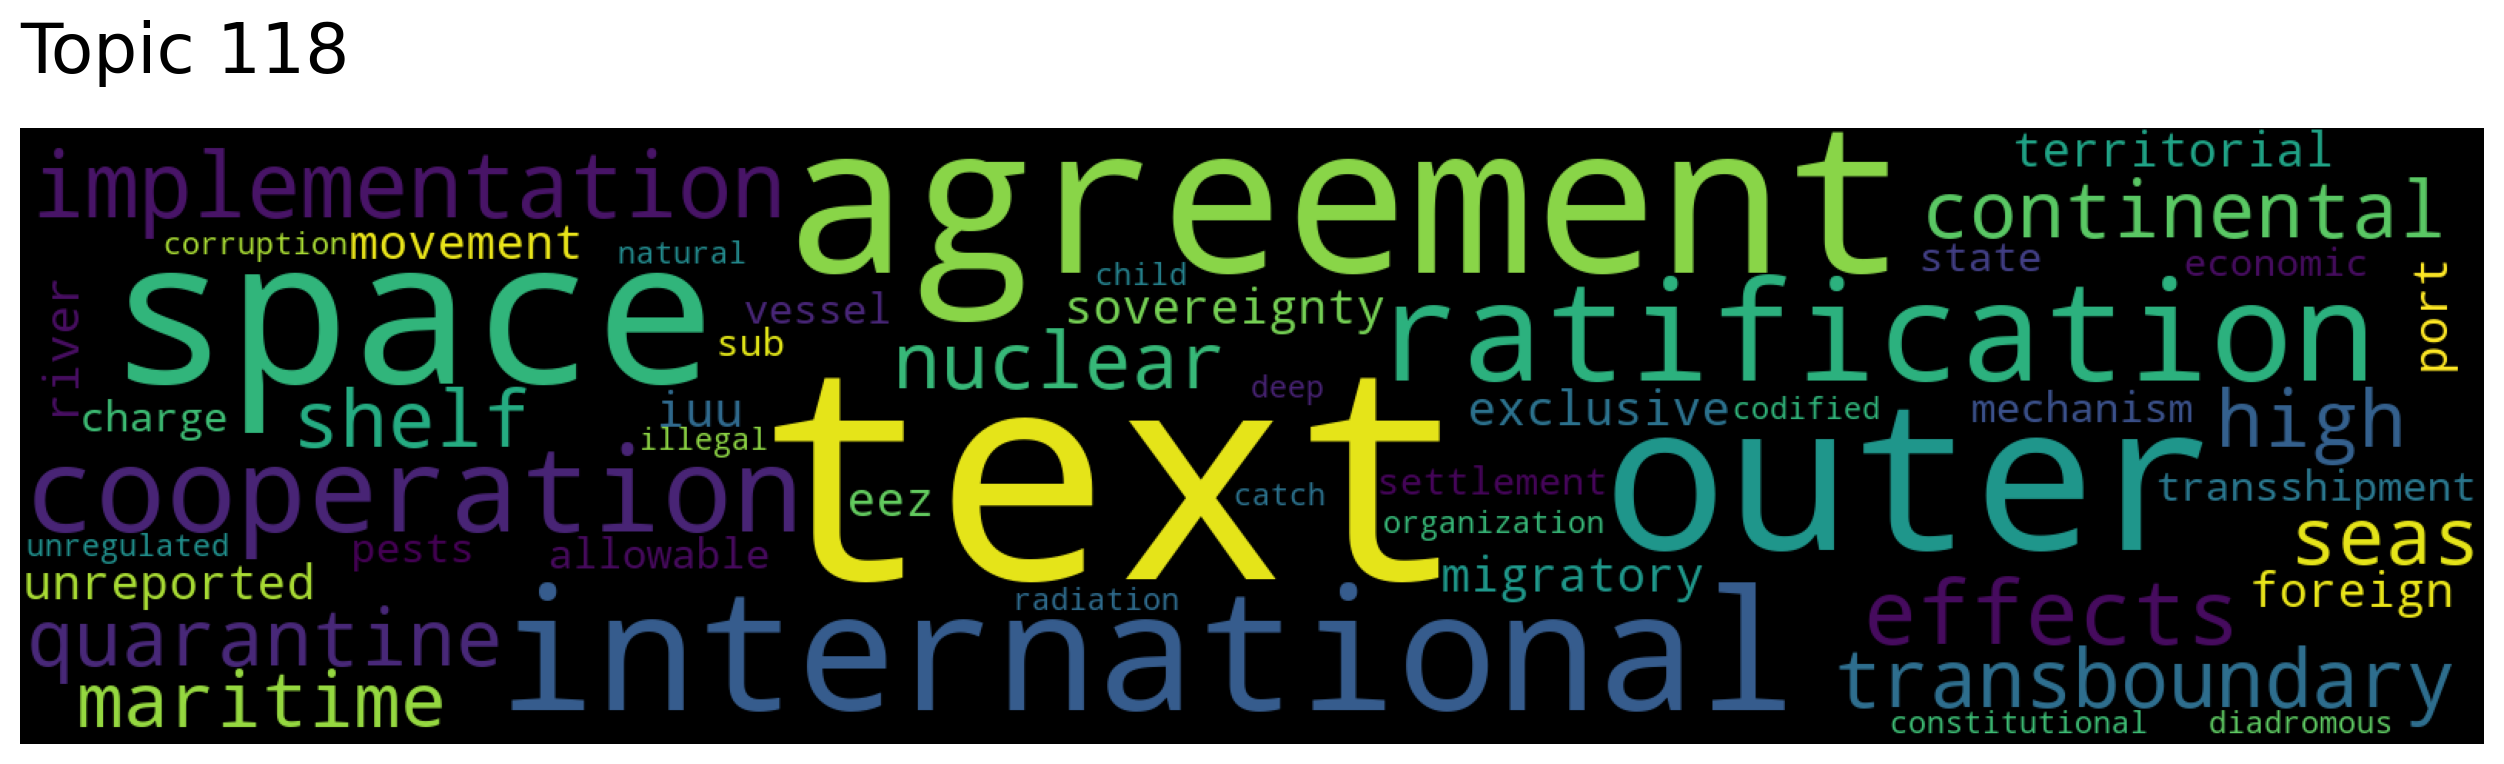

In [46]:
model.generate_topic_wordcloud(118,reduced=False)


In [17]:
import pandas as pd
#country data
income = pd.read_excel("CLASS.xlsx")
print(income.keys())

Index(['Economy', 'Code', 'Region', 'Income group', 'Lending category',
       'Other (EMU or HIPC)'],
      dtype='object')


In [18]:

income_countries = list(income["Economy"])
income_groups = list(income["Income group"])
income_listed_countries =[]
countries_income_dic ={}
for i in range(len(income_countries)):
    for j in range(len(countries_swap)):
        if income_countries[i] == countries_swap[j]:
            income_listed_countries.append(j)
            if income_groups[i] == "Low income":
                countries_income_dic[j]= 0
            elif income_groups[i] == "Lower middle income":
                countries_income_dic[j]= 1
            elif income_groups[i] == "Upper middle income":
                countries_income_dic[j]= 2
            elif income_groups[i] == "High income":
                countries_income_dic[j]= 3
missing_income_countries = []
missing_income_countries_names=[]
for i in countries_swap.keys():
    if i not in income_listed_countries:
        missing_income_countries.append(i)
        missing_income_countries_names.append(countries_swap[i])


In [19]:
from fuzzywuzzy import process
matches = []
threshold = 90  # Adjust the threshold as per your needs

for country1 in missing_income_countries_names:
    best_match = process.extractOne(country1, income_countries)
    if best_match[1] >= threshold:
        matches.append((country1, best_match[0]))


# Print the matches
for match in matches:
    print("Match:", match[0], "-", match[1])

print(len(matches))
print("matches found")

C:\Users\Jacob pc\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Match: Bermuda (UK) - Bermuda
Match: British Virgin Islands (UK) - British Virgin Islands
Match: United States of America - United States
Match: Saint Kitts and Nevis - St. Kitts and Nevis
Match: Saint Vincent and the Grenadines - St. Vincent and the Grenadines
Match: Cayman Islands (UK) - Cayman Islands
Match: Greenland (Denmark) - Denmark
Match: China, Hong Kong SAR - Hong Kong SAR, China
Match: Bolivia (Plurinational State of) - Bolivia
Match: United Kingdom of Great Britain and Northern Ireland - United Kingdom
Match: Côte d'Ivoire - Côte d’Ivoire
Match: Sao Tome and Principe - São Tomé and Príncipe
Match: Netherlands Antilles (Netherlands) - Netherlands
Match: United Republic of Tanzania - Tanzania
Match: Congo - Congo, Dem. Rep.
Match: Viet Nam - Vietnam
Match: Gambia - Gambia, The
Match: French Guiana (France) - France
Match: Niue (New Zealand) - New Zealand
Match: Guadeloupe (France) - France
Match: Martinique (France) - France
Match: Réunion (France) - France
Match: Egypt - Eg

In [20]:
for i,j in matches:
    if income_groups[income_countries.index(j)] == "Low income":
        countries_income_dic[countries[i]]= 0
    elif income_groups[income_countries.index(j)] == "Lower middle income":
        countries_income_dic[countries[i]]= 1
    elif income_groups[income_countries.index(j)] == "Upper middle income":
        countries_income_dic[countries[i]]= 2
    elif income_groups[income_countries.index(j)] == "High income":
        countries_income_dic[countries[i]]= 3


missing_income_countries = []
missing_income_countries_names=[]
for i in countries_swap.keys():
    if i not in countries_income_dic.keys():
        missing_income_countries.append(i)
        missing_income_countries_names.append(countries_swap[i])

In [21]:
extra_countries = [('Saint Barthélemy (FRA)',3),('Kyrgyzstan',1),('Andean Community',2),('Palestine',1),('Iran (Islamic Republic of)',1),('Slovakia',3),('Saint Helena, Ascension and Tristan da Cunha (UK)',3),('Jersey  (UK)',3),('Montserrat (UK)',3),('European Union',3),("Democratic People's Republic of Korea",0),('Falkland Islands (Malvinas)',3),
('Anguilla (UK)',3),('Cook Islands',3),('Micronesia (Federated States of)',1),('Republic of Korea',3),('MERCOSUR',2),('Democratic Republic of the Congo',0),('Guernsey (UK)',3),('Saint Lucia',2),('Czechia',3),('Venezuela (Bolivarian Republic of)',2),('Pitcairn (UK)',3),("Lao People's Democratic Republic",1)]


for i,j in extra_countries:
    countries_income_dic[countries[i]]= j

Text(0.5, 1.0, 'Countries in communities from Top2Vec model highlighted by income level')

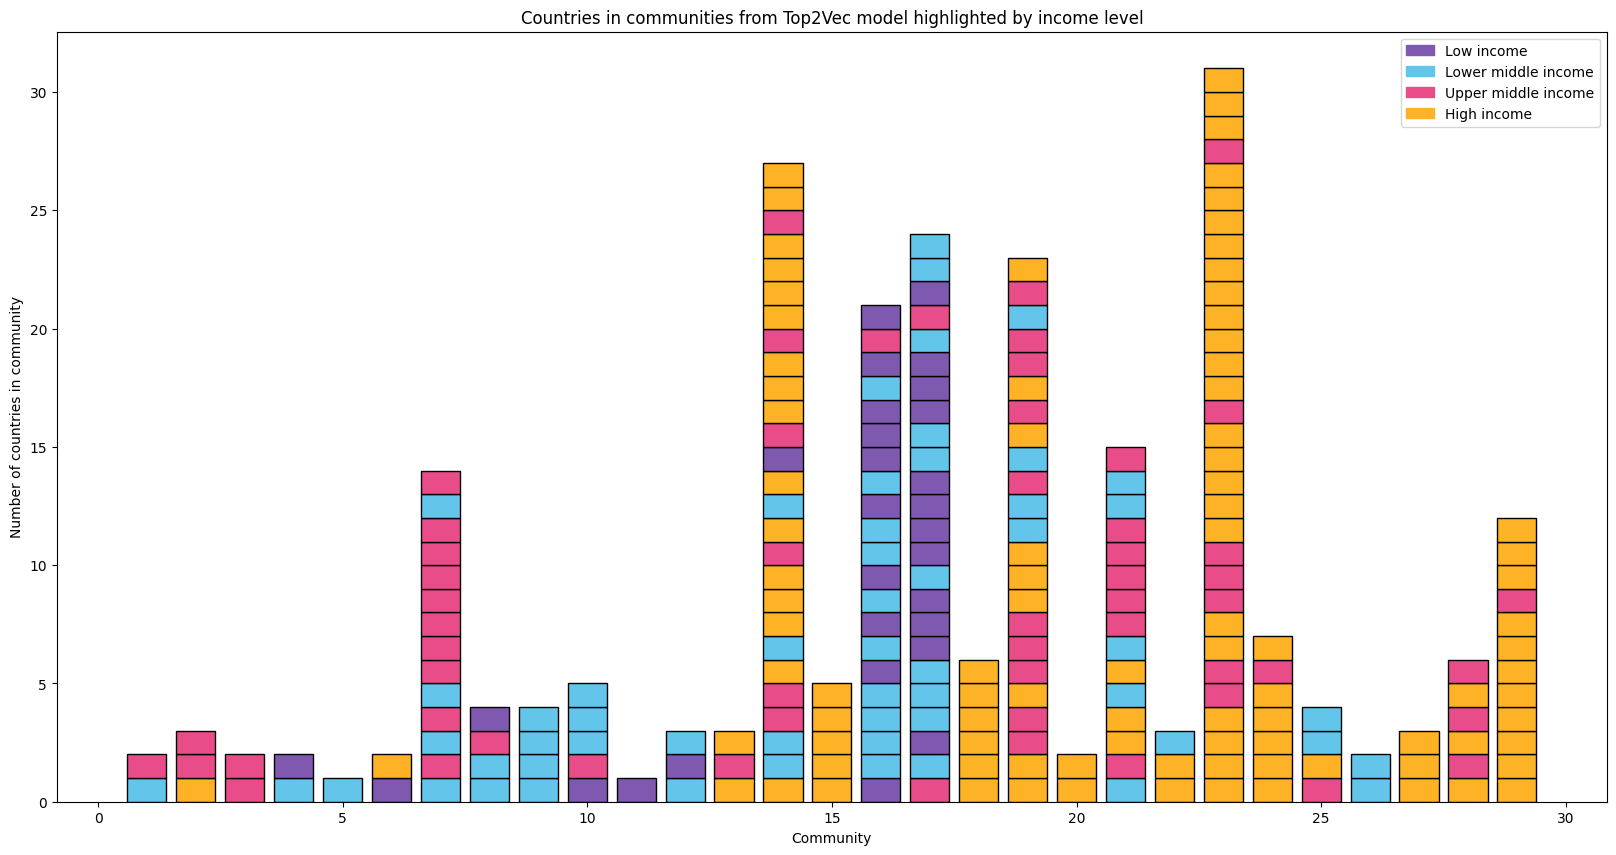

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure(figsize=(20, 10))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if countries_income_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 1, color="#7f58af",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 1, color="#64c5eb",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 1, color="#e84d8a",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 1, color="#feb326",width=0.8,edgecolor="#000000")
            h=1
        else:
            if countries_income_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 1, bottom=h, color="#7f58af",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 1, bottom=h, color="#64c5eb",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 1, bottom=h, color="#e84d8a",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 1, bottom=h, color="#feb326",width=0.8,edgecolor="#000000")
            h=h+1
pop_a = mpatches.Patch(color='#7f58af', label="Low income")
pop_b = mpatches.Patch(color='#64c5eb', label="Lower middle income")
pop_c = mpatches.Patch(color='#e84d8a', label="Upper middle income")
pop_d = mpatches.Patch(color='#feb326', label='High income')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d])
plt.xlabel("Community")
plt.ylabel("Number of countries in community")
plt.title("Countries in communities from Top2Vec model highlighted by income level")

In [23]:
print("Number of countries in different income groups + proportion")
print("Low: ",income_groups.count("Low income"),income_groups.count("Low income")/len(income_groups))
low_p = income_groups.count("Low income")/len(income_groups)
print("Lower middle: ",income_groups.count("Lower middle income"),income_groups.count("Lower middle income")/len(income_groups))
lowermiddle_p = income_groups.count("Lower middle income")/len(income_groups)
print("Upper middle: ",income_groups.count("Upper middle income"),income_groups.count("Upper middle income")/len(income_groups))
uppermiddle_p = income_groups.count("Upper middle income")/len(income_groups)
print("High: ",income_groups.count("High income"),income_groups.count("High income")/len(income_groups))
high_p = income_groups.count("High income")/len(income_groups)

Number of countries in different income groups + proportion
Low:  28 0.10566037735849057
Lower middle:  54 0.2037735849056604
Upper middle:  54 0.2037735849056604
High:  81 0.30566037735849055


# Governance

In [24]:
#country governance data
governance = pd.read_excel("governence data update.xlsx")
print(governance.keys())
governance_country = []
categorized_governance = []

for est,c in zip(governance["Estimate"],governance["Country/Territory"]):
    if est >=1:
        categorized_governance.append(3)
        governance_country.append(c)
    elif est>=0 and est<1:
        categorized_governance.append(2)
        governance_country.append(c)
    elif est>-1 and est<0:
        categorized_governance.append(1)
        governance_country.append(c)
    elif est<=-1:
        categorized_governance.append(0)
        governance_country.append(c)

Index(['Country/Territory', 'Estimate'], dtype='object')


In [25]:
#income_countries = list(income["Economy"])
#income_groups = list(income["Income group"])
governance_listed_countries =[]
governance_dic={}
for i in range(len(governance_country)):
    for j in range(len(countries_swap)):
        if governance_country[i] == countries_swap[j]:
            governance_listed_countries.append(j)
            governance_dic[j]=categorized_governance[i]
missing_gov_countries = []
missing_gov_countries_names=[]
for i in countries_swap.keys():
    if i not in governance_listed_countries:
        missing_gov_countries.append(i)
        missing_gov_countries_names.append(countries_swap[i])

In [26]:
from fuzzywuzzy import process
matches = []
threshold = 90  # Adjust the threshold as per your needs

for country1 in missing_gov_countries_names:
    best_match = process.extractOne(country1, governance_country)
    if best_match[1] >= threshold:
        matches.append((country1, best_match[0]))


# Print the matches
for match in matches:
    print("Match:", match[0], "-", match[1])

print(len(matches))
print("matches found")


KeyboardInterrupt



In [ ]:
for i,j in matches:
    governance_dic[countries[i]]=categorized_governance[governance_country.index(j)]

missing_gov_countries = []
missing_gov_countries_names=[]
for i in countries_swap.keys():
    if i not in governance_dic.keys():
        missing_gov_countries.append(i)
        missing_gov_countries_names.append(countries_swap[i])

In [ ]:
# Extra countries, 5 = Nan
extra_countries = [('Saint Barthélemy (FRA)',5),("Isle of Man (UK)",5),('Kyrgyzstan',1),('Andean Community',5),('Palestine',0),('Iran (Islamic Republic of)',0),('Slovakia',2),("Curaçao",5),('Saint Helena, Ascension and Tristan da Cunha (UK)',5),('Jersey  (UK)',3),('Montserrat (UK)',3),("Bermuda (UK)",5),("Cabo Verde",5),('European Union',5),("Democratic People's Republic of Korea",0),('Falkland Islands (Malvinas)',5),
('Anguilla (UK)',5),('Cook Islands',3),('Micronesia (Federated States of)',3),('Republic of Korea',2),("Northern Mariana Islands (USA)",3),('MERCOSUR',5),("British Virgin Islands (UK)",5),('Democratic Republic of the Congo',0),('Guernsey (UK)',3),('Saint Lucia',2),('Czechia',3),('Venezuela (Bolivarian Republic of)',0),('Pitcairn (UK)',3),("Lao People's Democratic Republic",0),("Turks and Caicos Islands (UK)",5),("Gibraltar (UK)",5),
("Taiwan Province of China",3),("South Georgia and the South Sandwich Islands (UK)",5)]


for i,j in extra_countries:
    governance_dic[countries[i]]= j

In [ ]:
plt.figure(figsize=(20, 10))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if governance_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 1, color="#809bce",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 1, color="#95b8d1",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 1, color="#b8e0d2",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 1, color="#eac4d5",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 5:
                plt.bar(j+1, 1, color="#808080",width=0.8,edgecolor="#000000")
            h=1
        else:
            if governance_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 1, bottom=h, color="#809bce",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 1, bottom=h, color="#95b8d1",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 1, bottom=h, color="#b8e0d2",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 1, bottom=h, color="#eac4d5",width=0.8,edgecolor="#000000")
            elif governance_dic[communities[j+1][i]] == 5:
                plt.bar(j+1, 1, bottom=h, color="#808080",width=0.8,edgecolor="#000000")
            h=h+1
pop_a = mpatches.Patch(color='#809bce', label="Weak Government Effectiveness")
pop_b = mpatches.Patch(color='#95b8d1', label="Lower Middle Government Effectiveness")
pop_c = mpatches.Patch(color='#b8e0d2', label="Upper Middle Government Effectiveness")
pop_d = mpatches.Patch(color='#eac4d5', label='Strong Government Effectiveness')
pop_e = mpatches.Patch(color='#808080', label='No data')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d,pop_e])
plt.xlabel("Community")
plt.ylabel("Number of countries in community")
plt.title("Countries in communities from Top2Vec model highlighted by government effectiveness")

In [ ]:
for c in communities[26]:
    print(countries_swap[c],governance_dic[c])

In [ ]:
print("Number of countries in different government effectiveness classes + proportion")
low_p = list(governance_dic.values()).count(0)/len(income_groups)
print("Low: ",list(governance_dic.values()).count(0),low_p)
lowermiddle_p = list(governance_dic.values()).count(1)/len(income_groups)
print("Lower middle: ",list(governance_dic.values()).count(1),lowermiddle_p)
uppermiddle_p = list(governance_dic.values()).count(2)/len(income_groups)
print("Upper middle: ",list(governance_dic.values()).count(2),uppermiddle_p)
high_p = list(governance_dic.values()).count(3)/len(income_groups)
print("High: ",list(governance_dic.values()).count(3),high_p)


# Temperature

In [ ]:
#country tempreature data
temperature = pd.read_excel("hottest-countries-in-the-world-2023.xlsx")
print(temperature.keys())
temperature_country = list(temperature["country"])
temp = list(temperature["averageTemperature"])


In [ ]:
for i in range(len(temp)):
    if temp[i]<=5:
        temp[i]=0
    elif temp[i]> 5 and temp[i]<=14:
        temp[i]=1
    elif temp[i]>14 and temp[i]<=23:
        temp[i]=2
    elif temp[i] >23:
        temp[i]=3

In [ ]:
temp_listed_countries =[]
temp_dic={}
for i in range(len(temperature_country)):
    for j in range(len(countries_swap)):
        if temperature_country[i] == countries_swap[j]:
            temp_listed_countries.append(j)
            temp_dic[j]=temp[i]
missing_temp_countries = []
missing_temp_countries_names=[]
for i in countries_swap.keys():
    if i not in temp_listed_countries:
        missing_temp_countries.append(i)
        missing_temp_countries_names.append(countries_swap[i])

In [ ]:
for c in countries_swap.keys():
    if c not in temp_dic.keys():
        temp_dic[c] = "NaN"

In [ ]:


plt.figure(figsize=(20, 10))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if temp_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 1, color="#094A25",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 1, color="#0C6B37",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 1, color="#EB442C",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 1, color="#BC2023",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == "NaN":
                plt.bar(j+1, 1, color="#808080",width=0.8,edgecolor="#000000")
            h=1
        else:
            if temp_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 1, bottom=h, color="#094A25",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 1, bottom=h, color="#0C6B37",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 1, bottom=h, color="#EB442C",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 1, bottom=h, color="#BC2023",width=0.8,edgecolor="#000000")
            elif temp_dic[communities[j+1][i]] == "NaN":
                plt.bar(j+1, 1, bottom=h, color="#808080",width=0.8,edgecolor="#000000")
            h=h+1
pop_a = mpatches.Patch(color='#094A25', label="Low temperature")
pop_b = mpatches.Patch(color='#0C6B37', label="Lower Middle Temperature")
pop_c = mpatches.Patch(color='#EB442C', label="Upper Middle Temperature")
pop_d = mpatches.Patch(color='#BC2023', label='High Temperature')
pop_e = mpatches.Patch(color='#808080', label='No data')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d,pop_e])
plt.xlabel("Community")
plt.ylabel("Number of countries in community")
plt.title("Countries in communities from Top2Vec model highlighted by mean temperature")

In [ ]:
for c in communities[12]:
    print(countries_swap[c],temp_dic[c])

In [ ]:
print("Number of countries in different temperature classes + proportion")
low_p = list(temp_dic.values()).count(0)/len(temp)
print("Low: ",list(temp_dic.values()).count(0),low_p)
lowermiddle_p = list(temp_dic.values()).count(1)/len(temp)
print("Lower middle: ",list(temp_dic.values()).count(1),lowermiddle_p)
uppermiddle_p = list(temp_dic.values()).count(2)/len(temp)
print("Upper middle: ",list(temp_dic.values()).count(2),uppermiddle_p)
high_p = list(temp_dic.values()).count(3)/len(temp)
print("High: ",list(temp_dic.values()).count(3),high_p)


In [ ]:
# mutual imformation calculation

# data pre-processing
c_assign = []
for i in range(500):
    if i in community_assignment:
        c_assign.append(community_assignment[i])


In [ ]:
XX = []
for i in range(500):
    if i in countries_income_dic:
        XX.append(countries_income_dic[i])

XX2 = []
for i in range(500):
    if i in community_assignment:
        XX2.append(XX[i])

XXX = []
for i in range(500):
    if i in governance_dic:
        XXX.append(governance_dic[i])

XXX3 = []
for i in range(500):
    if i in community_assignment:
        XXX3.append(XXX[i])
from sklearn.metrics import normalized_mutual_info_score

X = []

for i in range(500):
    if i in temp_dic:
        X.append(temp_dic[i])

X2 = []
for i in temp_dic:
    if i in community_assignment:
        X2.append(X[i])

In [ ]:

mi1 = normalized_mutual_info_score(XX2, c_assign)
print("normalized mi for income ", mi1)


mi2 = normalized_mutual_info_score(XXX3, c_assign)
print("normalized mi for governance ", mi2)


mi3 = normalized_mutual_info_score(X2, c_assign)
print("normalized mi for temp ", mi3)



In [ ]:
#word clouds

model.generate_topic_wordcloud(5,reduced=False)